### Task 3: Implement a support vector machine (SVM) to classify images of cats and dogs from the Kaggle dataset.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4387.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4255.jpg
/kaggle/

### 1. Imports
Let's first import all the libraries that required to perform this task.

In [44]:
!pip install python-resize-image
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from PIL import Image
from torchvision.datasets import ImageFolder
from resizeimage import resizeimage
from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from IPython.display import display
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### 2. Load the dataset

In [4]:
# importing images using torchvision
dataset = ImageFolder("../input/cat-and-dog/training_set/training_set/")

In [5]:
# creating labels dataframe
imgs, labels = zip(*dataset.imgs)
imgs = list(imgs)
labels = list(labels)
labels_df = pd.DataFrame({'image': imgs, 'label':labels})
labels_df

,image,label
0,../input/cat-and-dog/training_set/training_set...,0
1,../input/cat-and-dog/training_set/training_set...,0
2,../input/cat-and-dog/training_set/training_set...,0
3,../input/cat-and-dog/training_set/training_set...,0
4,../input/cat-and-dog/training_set/training_set...,0
...,...,...
8000,../input/cat-and-dog/training_set/training_set...,1
8001,../input/cat-and-dog/training_set/training_set...,1
8002,../input/cat-and-dog/training_set/training_set...,1
8003,../input/cat-and-dog/training_set/training_set...,1


### 3. Data Analysis and Preprocessing
Let's analyze our new data.

#### Exploring images of dataset
Let's see what kind of images does the dataset provide and see what kind of preprocessing needs to be done. 

In [6]:
def get_image(path):
    img = Image.open(path)
    return np.array(img)

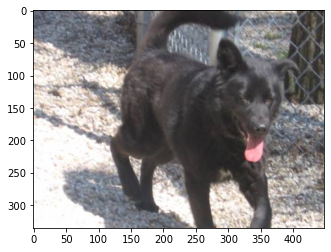

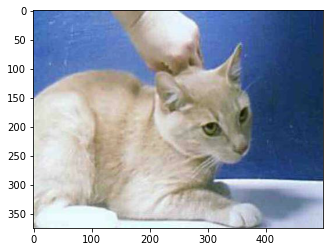

In [8]:
# showing a dog image
dog_row = labels_df[labels_df.label == 1].reset_index().image[43]
plt.imshow(get_image(dog_row))
plt.show()

# showing a cat image
cat_row = labels_df[labels_df.label == 0].reset_index().image[59]
plt.imshow(get_image(cat_row))
plt.show()

Okay, the images vary widely in terms of resolution and aspect ratio. Since the subject is in the middle for *most* images we can just resize to our desired resolution and crop from the middle.

Also the color channels may help in classifying, so let's just keep it.

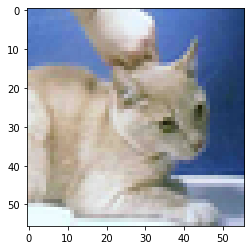

In [23]:
# Image manupulation
img = Image.open(cat_row)
img = resizeimage.resize_cover(img, [56, 56])
plt.imshow(np.array(img), cmap='gray')
plt.show()

#### Histogram of oriented gradients
We've got a matrix of pixel values, but those don't contain enough interesting information on their own for most algorithms. We need to help the algorithms along by picking out some of the salient features for them using the **histogram of oriented gradients** (s shape within an image can be inferred by its edges, and a way to identify edges is by looking at the direction of intensity gradients (i.e. changes in luminescence).
![HOG](https://scikit-image.org/docs/dev/_images/sphx_glr_plot_hog_001.png)

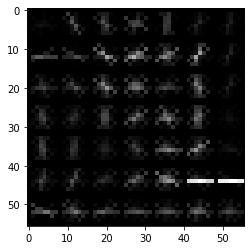

In [24]:
hog_features, hog_img = hog(img, visualize=True, block_norm='L2-Hys', pixels_per_cell=(8,8))
plt.imshow(np.array(hog_img), cmap='gray')
plt.show()

### 4. Create image features and flatten into a single row
Algorithms require data to be in a format where rows correspond to images and columns correspond to features. This means that all the information for a given image needs to be contained in a single row.

We want to provide our model with the raw pixel values from our images as well as the HOG features we just calculated. Let's do it!

In [25]:
def create_features(path):
    img = Image.open(path)
    img = resizeimage.resize_cover(img, [56, 56])
    img_arr = np.array(img)
    # flatten three channel color image
    color_features = img_arr.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img_arr)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(8, 8))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

dog_features = create_features(dog_row)
print(dog_features.shape)

(11433,)


**Loop over images to preprocess**   
Above we generated a flattened features array for a dog image. Now it's time to loop over all of our images. We will create features for each image and then stack the flattened features arrays into a big matrix we can pass into our model.
In the resulting features matrix, rows correspond to images and columns to features.

In [26]:
def create_feature_matrix(label_df):
    features_list = []
    
    for img_path in labels_df.image:
        # get features for image
        img_features = create_features(img_path)
        features_list.append(img_features)
    
    feature_matrix = np.array(features_list)
    return feature_matrix

feature_matrix = create_feature_matrix(labels_df)

**Scale feature matrix**   
Our features aren't quite done yet. Many machine learning methods are built to work best with data that has a mean of 0 and unit variance. So let's scale the features using the StandardScaler provided by scikit-learn

In [28]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
imgs_stand = ss.fit_transform(feature_matrix)

Feature matrix shape is:  (8005, 11433)


**Split into train and test sets**   
Now we need to convert our data into train and test sets. We'll use 80% of images as our training data and test our model on the remaining 20%.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(imgs_stand,
                                                    labels_df.label.values,
                                                    test_size=.2,
                                                    random_state=42)

In [30]:
# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

1    3223
0    3181
dtype: int64

### 5. Model building and training
Now let's finally build our model! We'll do this using an SVM classifier with a linear kernel.

In [31]:
# define support vector classifier
svm = SVC(kernel='rbf',probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(probability=True, random_state=42)

### 6. Model Evaluation
Now let's use our trained model to generate predictions for our data and see how it does. 

In [32]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.7282948157401624


72%.. Not bad for a simple SVC model using such complicated data.. Probably better to use Deep Learning though UwU

In [36]:
target_names = ['cat', 'dog']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         cat       0.73      0.74      0.74       819
         dog       0.73      0.71      0.72       782

    accuracy                           0.73      1601
   macro avg       0.73      0.73      0.73      1601
weighted avg       0.73      0.73      0.73      1601



In [38]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[607 212]
 [223 559]]


**Visualizing Predictions**   
Let's take random images from the test set and predict and display them individually. Here's we'll realize how bad this model is TwT

In [41]:
from random import randint

test = ImageFolder("../input/cat-and-dog/test_set/test_set/")
imgs, labels = zip(*test.imgs)
imgs = list(imgs)
labels = list(labels)

Prediction: Dog
Actual: Dog


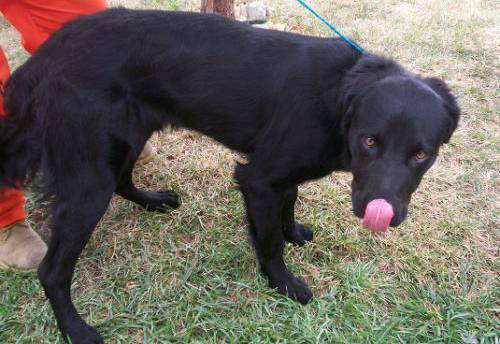

In [42]:
random_ix = randint(0, len(imgs))
label = {0: 'Cat', 1:'Dog'}
rand_img = imgs[random_ix]
# create features of the image
test_features = create_features(rand_img)
# predict
prediction = svm.predict([test_features])
print("Prediction: " + label[prediction[0]])
print("Actual: " + label[labels[random_ix]])
# display image
display(Image.open(rand_img))

### 7. Model Saving
Lets save our model in pickel form so that we can deploy it in the future.

In [45]:
# Save the model to a pickle file
with open('catvsdog.pkl', 'wb') as file:
    pickle.dump(svm, file)

In [46]:
# Sanity check
with open('catvsdog.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

### 8. Conclusion
In conclusion, it is found that, we successfully did all the steps from loading dataset to model saving that are required in order to implement a support vector machine (SVM) to classify images of cats and dogs and found testing accuracy of 72%.